#  <font color='#FFE15D'><b>💎 UW-Madison GI Tract Image Segmentation 🔬</b></font>
![Image Title](https://github.com/ARHPA/medical-image-segmentation/blob/master/images/cover.png?raw=1)

# 🔴 **Environment Setup**

## 🟠 install the `torchmetrics` library.

In [1]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 9.8 MB/s eta 0:00:00


## 🟠 Install `portalocker`

In [2]:
!pip install -q portalocker>=2.0.0

## 🟠 Install `wandb`

In [3]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00


# ⚠️ **Don't forget to restart the runtime!**

# 🔴 **Import Libs**

In [4]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=1a31c443fd8e4a1595fc8725ef7a84c855f67f0b7a7468443d588b2f7176c3cd
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=d31a7312bc83c6f5c76cb912e2a3d67f335d9b78d48fd5ca4fd1756fcaaff56a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [5]:
import os
import sys
import time
import random
import tqdm
import shutil
from glob import glob
import zipfile

import wandb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
from torch import optim

import torchvision
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.datasets import VisionDataset
from torchvision.transforms import v2
from torchvision import tv_tensors

import segmentation_models_pytorch as smp

import torchmetrics as tm
from torchmetrics.aggregation import MeanMetric
from torchmetrics import Dice

In [6]:
!python --version

Python 3.10.12


In [7]:
for lib in [np, torch, torchvision, tm, tqdm, smp]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.25.2
torch --> 2.2.1+cu121
torchvision --> 0.17.1+cu121
torchmetrics --> 1.3.2
tqdm --> 4.66.2
segmentation_models_pytorch --> 0.3.3


# 🔴 **Utils**

In [8]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [9]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      # torch.cuda.manual_seed_all(seed)

      # torch.backends.cudnn.deterministic = True
      # torch.backends.cudnn.benchmark = False


# 🔴 **Arguments**

In [10]:
seed = 8
wandb_enable = False
root = 'uw-madison-image-segmentation'
batch_size = 32
backbone = 'efficientnet-b1'
num_classes = 3
classes = ['large_bowel', 'small_bowel', 'stomach']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.1
momentum = 0.9
wd = 1e-4
num_epochs = 20

In [11]:
if wandb_enable:
  wandb_arg_name = input('Please input the WandB argument (run) name:')
  print(wandb_arg_name)

# 🔴 **Dataset**

## 🟠 Load the Dataset

### 🟡 Connect to Kaggle

In [12]:
!pip install -q kaggle

In [13]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amirreza8521941","key":"ace103961a6cb4339d90ad9d1e2e637b"}'}

In [14]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                             title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                          Netflix Movies and TV Shows                         1MB  2024-04-10 09:48:38          12681        268  1.0              
sahirmaharajj/school-student-daily-attendance                   School Student Daily Attendance                     2MB  2024-04-29 19:29:56           1547         36  1.0              
jaidalmotra/pokemon-dataset                                     Pokemon Dataset                                    19KB  2024-04-30 10:38:36           1071         36  1.0              
fahadrehman07/retail-transaction-dataset                        Retail

### 🟡 Download Dataset from Kaggle

In [15]:
!kaggle competitions download -c uw-madison-gi-tract-image-segmentation

100% 2.29G/2.30G [00:36<00:00, 66.9MB/s]
100% 2.30G/2.30G [00:36<00:00, 67.0MB/s]


In [16]:
os.makedirs('uw-madison-image-segmentation', exist_ok=True)
with zipfile.ZipFile('uw-madison-gi-tract-image-segmentation.zip', 'r') as zip_ref:
    zip_ref.extractall('uw-madison-image-segmentation')

In [17]:
os.remove('uw-madison-gi-tract-image-segmentation.zip')

### 🟡 Download train.txt, validation.txt, test.txt

In [18]:
!git clone https://github.com/ARHPA/medical-image-segmentation.git

Cloning into 'medical-image-segmentation'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 47 (delta 10), reused 34 (delta 5), pack-reused 0
Receiving objects: 100% (47/47), 5.34 MiB | 13.46 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [19]:
shutil.move('medical-image-segmentation/train_test_split/test.txt', 'uw-madison-image-segmentation/test.txt')
shutil.move('medical-image-segmentation/train_test_split/train.txt', 'uw-madison-image-segmentation/train.txt')
shutil.move('medical-image-segmentation/train_test_split/validation.txt', 'uw-madison-image-segmentation/validation.txt')

'uw-madison-image-segmentation/validation.txt'

In [20]:
!rm -rf /content/medical-image-segmentation

### 🟡 Load and show an image


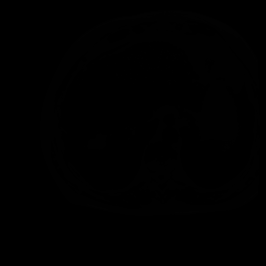

In [21]:
img_path = r"/content/uw-madison-image-segmentation/train/case15/case15_day20/scans/slice_0053_266_266_1.50_1.50.png"

img = Image.open(img_path)
img

In [22]:
img_tensor = F.to_tensor(img)
img_tensor.shape, img_tensor.dtype, img_tensor.min(), img_tensor.max()

(torch.Size([1, 266, 266]),
 torch.int32,
 tensor(0, dtype=torch.int32),
 tensor(612, dtype=torch.int32))

In [23]:
normalizer = lambda x: (x - x.min()) / (x.max() - x.min())

In [24]:
img_norm = normalizer(img_tensor)
img_norm.dtype, img_norm.min(), img_norm.max()

(torch.float32, tensor(0.), tensor(1.))

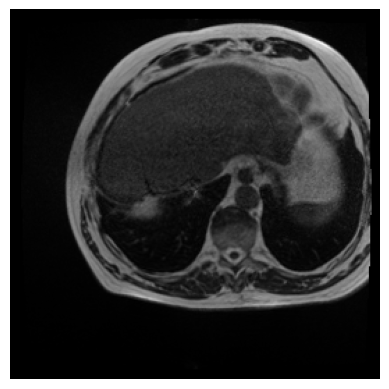

In [25]:
plt.imshow(img_norm[0], cmap='gray')
plt.axis('off');

In [26]:
img = Image.open(img_path).convert('RGB')
img = F.to_tensor(img)
img.shape, img.dtype, img.min(), img.max()

(torch.Size([3, 266, 266]), torch.float32, tensor(0.), tensor(1.))

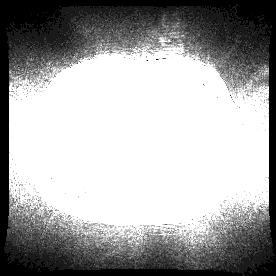

In [27]:
img_path = r"uw-madison-image-segmentation/train/case34/case34_day16/scans/slice_0026_276_276_1.63_1.63.png"
img = Image.open(img_path).convert('RGB')
img

In [28]:
img = np.array(img)
img.shape, img.dtype, img.min(), img.max()

((276, 276, 3), dtype('uint8'), 0, 255)

In [29]:
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
img.shape, img.dtype, img.min(), img.max()

((276, 276), dtype('uint16'), 0, 12220)

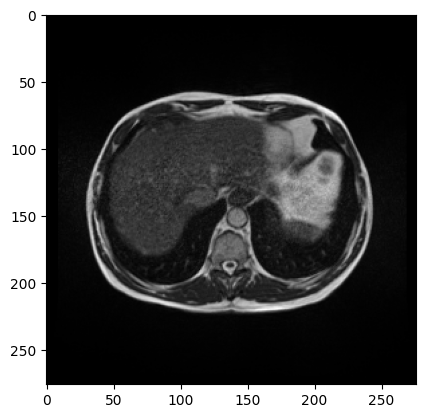

In [30]:
plt.imshow(img, cmap='gray')

float64
torch.Size([276, 276]) torch.float32 tensor(0.) tensor(1.)


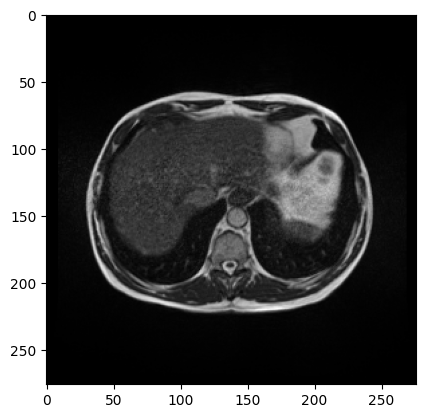

In [31]:
img = normalizer(img)
print(img.dtype)
img_tensor = torch.tensor(img, dtype=torch.float32)
print(img_tensor.shape, img_tensor.dtype, img_tensor.min(), img_tensor.max())
plt.imshow(img_tensor, cmap='gray')

### 🟡 Load and show a segmentation mask


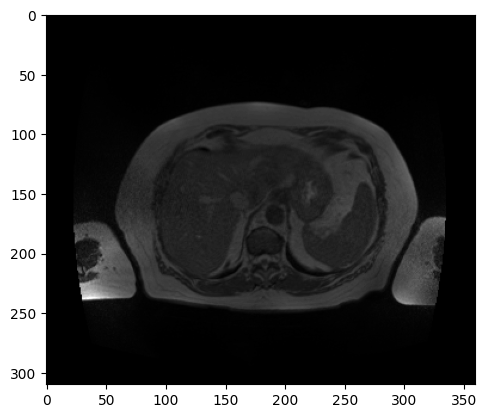

In [32]:
img_path = r"uw-madison-image-segmentation/train/case11/case11_day0/scans/slice_0039_360_310_1.50_1.50.png"
img = Image.open(img_path)
img = F.to_tensor(img)
img = normalizer(img[0])
plt.imshow(img, cmap='gray');

In [33]:
mask_name = 'case11_day0_slice_0039'
df = pd.read_csv(r'uw-madison-image-segmentation/train.csv')
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [34]:
sample = df[df['id'] == mask_name]
rle_mask = sample.iloc[2]['segmentation']
rle_mask

'47020 9 47378 12 47736 15 48095 16 48454 18 48813 20 49172 22 49532 23 49891 26 50251 27 50611 28 50970 30 51330 30 51690 30 52049 32 52409 32 52768 32 53113 8 53126 34 53470 50 53829 50 54189 50 54548 51 54908 50 55268 50 55628 49 55989 48 56350 47 56713 43 57078 37 57441 33 57803 31 58165 28 58527 26 58889 23 59250 21 59611 20 59972 18 60333 16 60695 13 61056 10 61418 7 61781 1'

In [35]:
rle_list = rle_mask.split(' ')
starts, lengths = rle_list[::2], rle_list[1::2]
starts = np.array(starts, dtype=np.int32) - 1
lengths = np.array(lengths, dtype=np.int32)
ends = starts + lengths
starts, lengths, ends

(array([47019, 47377, 47735, 48094, 48453, 48812, 49171, 49531, 49890,
        50250, 50610, 50969, 51329, 51689, 52048, 52408, 52767, 53112,
        53125, 53469, 53828, 54188, 54547, 54907, 55267, 55627, 55988,
        56349, 56712, 57077, 57440, 57802, 58164, 58526, 58888, 59249,
        59610, 59971, 60332, 60694, 61055, 61417, 61780], dtype=int32),
 array([ 9, 12, 15, 16, 18, 20, 22, 23, 26, 27, 28, 30, 30, 30, 32, 32, 32,
         8, 34, 50, 50, 50, 51, 50, 50, 49, 48, 47, 43, 37, 33, 31, 28, 26,
        23, 21, 20, 18, 16, 13, 10,  7,  1], dtype=int32),
 array([47028, 47389, 47750, 48110, 48471, 48832, 49193, 49554, 49916,
        50277, 50638, 50999, 51359, 51719, 52080, 52440, 52799, 53120,
        53159, 53519, 53878, 54238, 54598, 54957, 55317, 55676, 56036,
        56396, 56755, 57114, 57473, 57833, 58192, 58552, 58911, 59270,
        59630, 59989, 60348, 60707, 61065, 61424, 61781], dtype=int32))

In [36]:
mask = torch.zeros(img.numel(), dtype=torch.float32)

for start, end in zip(starts, ends):
  mask[start:end] = 1

mask.max()

tensor(1.)

torch.Size([310, 360])


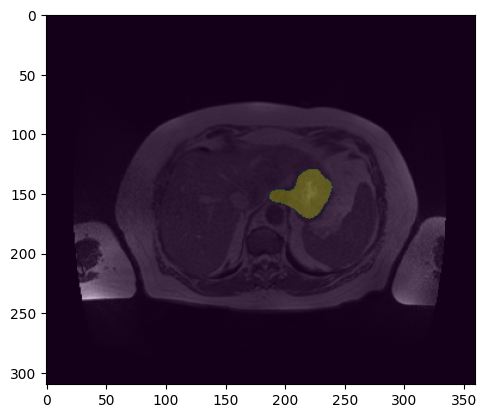

In [37]:
mask2 = mask.reshape(img.shape)
print(mask2.shape)

plt.imshow(img, cmap='gray')
plt.imshow(mask2, alpha=0.3);

In [38]:
x = torch.randint(0, 10, (3, 3))
x, x.flatten(), x.reshape(-1)

(tensor([[9, 6, 6],
         [7, 7, 3],
         [3, 2, 9]]),
 tensor([9, 6, 6, 7, 7, 3, 3, 2, 9]),
 tensor([9, 6, 6, 7, 7, 3, 3, 2, 9]))

In [39]:
x = torch.randint(0, 10, (9,))
x, x.reshape(3, 3)

(tensor([9, 6, 6, 6, 9, 6, 2, 7, 9]),
 tensor([[9, 6, 6],
         [6, 9, 6],
         [2, 7, 9]]))

## 🟠 Dataset preparation

### 🟡 Load CSV file


In [40]:
df = pd.read_csv(os.path.join(root, 'train.csv'))
display(df.head())
df.shape

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


(115488, 3)

In [41]:
df.describe()

,id,class,segmentation
count,115488,115488,33913
unique,38496,3,33899
top,case123_day20_slice_0001,large_bowel,12629 10 12894 12 13158 15 13423 17 13688 19 1...
freq,3,38496,2


### 🟡 Drop NaN values


In [42]:
df.dropna(inplace=True)
display(df.head())
df.shape

,id,class,segmentation
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...


(33913, 3)

### 🟡 Find duplicate rows


In [43]:
duplicates = df[df['segmentation'].duplicated(keep=False)]
duplicates

,id,class,segmentation
3259,case133_day25_slice_0079,small_bowel,29755 2 30112 8 30468 14 30826 17 31185 19 315...
3262,case133_day25_slice_0080,small_bowel,29755 2 30112 8 30468 14 30826 17 31185 19 315...
3638,case133_day23_slice_0061,stomach,34757 14 35114 19 35473 21 35831 23 36189 26 3...
3641,case133_day23_slice_0062,stomach,34757 14 35114 19 35473 21 35831 23 36189 26 3...
13134,case15_day20_slice_0059,large_bowel,28436 5 28701 7 28966 8 29232 9 29498 9 29765 ...
13137,case15_day20_slice_0060,large_bowel,28436 5 28701 7 28966 8 29232 9 29498 9 29765 ...
24745,case115_day0_slice_0105,small_bowel,16389 4 16648 15 16889 2 16913 24 17153 6 1717...
24748,case115_day0_slice_0106,small_bowel,16389 4 16648 15 16889 2 16913 24 17153 6 1717...
24751,case115_day0_slice_0107,small_bowel,16091 1 16114 4 16355 6 16379 8 16620 8 16644 ...
24754,case115_day0_slice_0108,small_bowel,16091 1 16114 4 16355 6 16379 8 16620 8 16644 ...


### 🟡 Create pivot table


In [44]:
df = df.pivot_table(index='id', columns='class', values='segmentation', aggfunc='first')
df.reset_index(inplace=True)
display(df.head())
df.shape

class,id,large_bowel,small_bowel,stomach
0,case101_day20_slice_0066,NaN,NaN,32107 5 32371 10 32635 13 32900 15 33165 17 33...
1,case101_day20_slice_0067,NaN,NaN,31313 2 31577 7 31841 10 32105 14 32369 17 326...
2,case101_day20_slice_0068,NaN,NaN,30517 2 30781 6 31046 9 31311 11 31575 15 3184...
3,case101_day20_slice_0069,NaN,NaN,29981 10 30246 13 30511 16 30776 19 31041 21 3...
4,case101_day20_slice_0070,NaN,NaN,28918 9 29182 14 29446 18 29711 21 29976 23 30...


(16590, 4)

### 🟡 Fill NaNs


In [45]:
df.fillna('', inplace=True)
df.head()

class,id,large_bowel,small_bowel,stomach
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...


### 🟡 Get image paths


In [46]:
images_list = glob(os.path.join(root, 'train', '**', '*.png'), recursive=True)
len(images_list), images_list[0]

(38496,
 'uw-madison-image-segmentation/train/case136/case136_day25/scans/slice_0046_360_310_1.50_1.50.png')

### 🟡 Create a dataframe contains image paths


In [47]:
comps = images_list[0].split(os.path.sep)
print(comps)
'_'.join([comps[-3], comps[-1]]).rsplit('_', 4)[0]

['uw-madison-image-segmentation', 'train', 'case136', 'case136_day25', 'scans', 'slice_0046_360_310_1.50_1.50.png']


'case136_day25_slice_0046'

In [48]:
image_path_list = glob(os.path.join(root, 'train', '**', '*.png'), recursive=True)

id_list = []
for i in range(0, len(image_path_list)):
  components = image_path_list[i].split(os.path.sep)[-3::2]
  id_list.append('_'.join([components[0], components[1]]).rsplit('_', 4)[0])

df_path = pd.DataFrame()
df_path['id'] = id_list
df_path['path'] = image_path_list
display(df_path.head())
df_path.shape

,id,path
0,case136_day25_slice_0046,uw-madison-image-segmentation/train/case136/ca...
1,case136_day25_slice_0063,uw-madison-image-segmentation/train/case136/ca...
2,case136_day25_slice_0094,uw-madison-image-segmentation/train/case136/ca...
3,case136_day25_slice_0006,uw-madison-image-segmentation/train/case136/ca...
4,case136_day25_slice_0001,uw-madison-image-segmentation/train/case136/ca...


(38496, 2)

### 🟡 Merge `df` and `df_path`


In [49]:
df = df.merge(df_path, on='id')
df.head()

,id,large_bowel,small_bowel,stomach,path
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...,uw-madison-image-segmentation/train/case101/ca...
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...,uw-madison-image-segmentation/train/case101/ca...
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,uw-madison-image-segmentation/train/case101/ca...
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...,uw-madison-image-segmentation/train/case101/ca...
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...,uw-madison-image-segmentation/train/case101/ca...


### 🟡 Augment dataFrame by adding new features


In [50]:
df['case'] = df['id'].apply(lambda x: x.split('_')[0].replace('case', ''))

df['day'] = df['id'].apply(lambda x: int(x.split('_')[1].replace('day', '')))

df['slice'] = df['id'].apply(lambda x: x.split('_')[3])

df['width'] = df['path'].apply(lambda x: int(x[:-4].rsplit("_", 4)[1]))

df['height'] = df['path'].apply(lambda x: int(x[:-4].rsplit("_", 4)[2]))

df['counts'] = np.sum(df.iloc[:, 1:4] != '', axis=1).values

display(df.head())
df['counts'].unique()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,counts
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...,uw-madison-image-segmentation/train/case101/ca...,101,20,0066,266,266,1
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...,uw-madison-image-segmentation/train/case101/ca...,101,20,0067,266,266,1
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,uw-madison-image-segmentation/train/case101/ca...,101,20,0068,266,266,1
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...,uw-madison-image-segmentation/train/case101/ca...,101,20,0069,266,266,1
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...,uw-madison-image-segmentation/train/case101/ca...,101,20,0070,266,266,1


array([1, 2, 3])

### 🟡 Create Train, Validation, and Test Subsets from the Dataset


#### ⚪ Train

In [51]:
train_cases = open(os.path.join(root, 'train.txt')).read().replace('case', '').split('\n')

In [52]:
df_train = df[df['case'].isin(train_cases)]
display(df_train.head())
df_train.shape

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,counts
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...,uw-madison-image-segmentation/train/case101/ca...,101,20,0066,266,266,1
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...,uw-madison-image-segmentation/train/case101/ca...,101,20,0067,266,266,1
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,uw-madison-image-segmentation/train/case101/ca...,101,20,0068,266,266,1
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...,uw-madison-image-segmentation/train/case101/ca...,101,20,0069,266,266,1
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...,uw-madison-image-segmentation/train/case101/ca...,101,20,0070,266,266,1


(12030, 11)

In [53]:
df_train.to_csv(os.path.join(root, 'train-subset.csv'), index=False)

#### ⚪ Validation

In [54]:
valid_cases = open(os.path.join(root, 'validation.txt')).read().replace('case', '').split('\n')
# valid_cases

In [55]:
df_valid = df[df['case'].isin(valid_cases)]
display(df_valid.head())
df_valid.shape

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,counts
2763,case122_day0_slice_0051,,,35851 9 36211 12 36571 14 36931 14 37291 15 37...,uw-madison-image-segmentation/train/case122/ca...,122,0,0051,360,310,1
2764,case122_day0_slice_0052,,,34414 2 34417 3 34772 8 35131 10 35490 12 3584...,uw-madison-image-segmentation/train/case122/ca...,122,0,0052,360,310,1
2765,case122_day0_slice_0053,,,34419 1 34778 4 35131 12 35489 16 35848 18 362...,uw-madison-image-segmentation/train/case122/ca...,122,0,0053,360,310,1
2766,case122_day0_slice_0054,,,33339 2 33697 6 34057 8 34416 10 34773 14 3512...,uw-madison-image-segmentation/train/case122/ca...,122,0,0054,360,310,1
2767,case122_day0_slice_0055,,,32257 4 32615 8 32974 11 33333 14 33692 16 340...,uw-madison-image-segmentation/train/case122/ca...,122,0,0055,360,310,1


(1493, 11)

In [56]:
df_valid.to_csv(os.path.join(root, 'valid-subset.csv'), index=False)

#### ⚪ Test

In [57]:
test_cases = open(os.path.join(root, 'test.txt')).read().replace('case', '').split('\n')
# test_cases

In [58]:
df_test = df[df['case'].isin(test_cases)]
display(df_test.head())
df_test.shape

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,counts
674,case110_day12_slice_0048,,,35874 3 36232 11 36591 14 36950 17 37310 18 37...,uw-madison-image-segmentation/train/case110/ca...,110,12,0048,360,310,1
675,case110_day12_slice_0049,,,34429 12 34788 15 35147 17 35506 19 35865 22 3...,uw-madison-image-segmentation/train/case110/ca...,110,12,0049,360,310,1
676,case110_day12_slice_0050,,,33709 6 34066 12 34424 18 34783 22 35141 26 35...,uw-madison-image-segmentation/train/case110/ca...,110,12,0050,360,310,1
677,case110_day12_slice_0051,,,33347 8 33705 14 34063 19 34421 24 34779 28 35...,uw-madison-image-segmentation/train/case110/ca...,110,12,0051,360,310,1
678,case110_day12_slice_0052,,,32988 6 33344 15 33702 20 34061 23 34419 26 34...,uw-madison-image-segmentation/train/case110/ca...,110,12,0052,360,310,1


(3067, 11)

In [59]:
df_test.to_csv(os.path.join(root, 'test-subset.csv'), index=False)

## 🟠 EDA

In [60]:
df_train = pd.read_csv(os.path.join(root, 'train-subset.csv'))
df_train.head()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,counts
0,case101_day20_slice_0066,NaN,NaN,32107 5 32371 10 32635 13 32900 15 33165 17 33...,uw-madison-image-segmentation/train/case101/ca...,101,20,66,266,266,1
1,case101_day20_slice_0067,NaN,NaN,31313 2 31577 7 31841 10 32105 14 32369 17 326...,uw-madison-image-segmentation/train/case101/ca...,101,20,67,266,266,1
2,case101_day20_slice_0068,NaN,NaN,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,uw-madison-image-segmentation/train/case101/ca...,101,20,68,266,266,1
3,case101_day20_slice_0069,NaN,NaN,29981 10 30246 13 30511 16 30776 19 31041 21 3...,uw-madison-image-segmentation/train/case101/ca...,101,20,69,266,266,1
4,case101_day20_slice_0070,NaN,NaN,28918 9 29182 14 29446 18 29711 21 29976 23 30...,uw-madison-image-segmentation/train/case101/ca...,101,20,70,266,266,1


### 🟡 Show an image and its mask


In [61]:
def rle_decode(img_size, segments):
  mask = torch.zeros(3, img_size[0] * img_size[1], dtype=torch.float32)
  for i, segment in enumerate(segments):
    if str(segment) != 'nan':
      segment = segment.split()
      starts = np.array(segment[::2], dtype=np.int32) - 1
      ends = starts + np.array(segment[1::2], dtype=np.int32)
      for s, e in zip(starts, ends):
        mask[i, s:e] = 1
  return mask.reshape((3, img_size[0], img_size[1]))

In [62]:
train_transform = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min())),
                                      transforms.Lambda(lambda x: x.repeat(3, 1, 1))])

target_transform = transforms.Compose([transforms.Resize((224, 224))])

red: large_bowel, green: small_bowel, blue: stomach


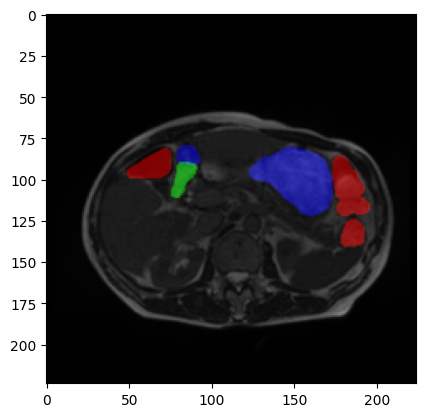

In [63]:
item = random.randint(0, df_train.shape[0])
sample = df_train.iloc[item]

img = Image.open(sample['path'])

mask = rle_decode(img.size[::-1], sample[['large_bowel', 'small_bowel', 'stomach']])

img = train_transform(img)
mask = target_transform(mask)

plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.imshow(mask.permute(1, 2, 0), alpha=0.5)
print('red: large_bowel, green: small_bowel, blue: stomach');

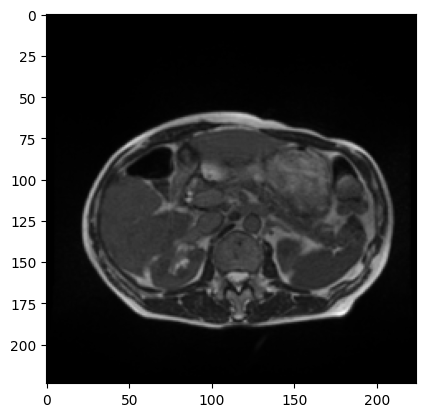

In [64]:
plt.imshow(img.permute(1, 2, 0), cmap='gray')

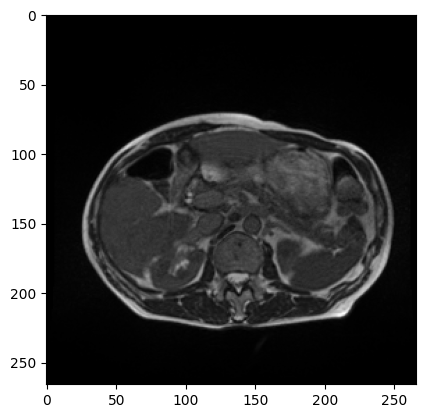

In [65]:
img_temp = cv2.imread(sample['path'], cv2.IMREAD_UNCHANGED)
img_temp.shape, img_temp.dtype, img_temp.min(), img_temp.max()
img_temp = normalizer(img_temp)
plt.imshow(img_temp, cmap='gray')

### 🟡 Show a day in animation


### 🟡 Plot histogram of the number of samples in each class


In [66]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12030 entries, 0 to 12029
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           12030 non-null  object
 1   large_bowel  10143 non-null  object
 2   small_bowel  8190 non-null   object
 3   stomach      6191 non-null   object
 4   path         12030 non-null  object
 5   case         12030 non-null  int64 
 6   day          12030 non-null  int64 
 7   slice        12030 non-null  int64 
 8   width        12030 non-null  int64 
 9   height       12030 non-null  int64 
 10  counts       12030 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 1.0+ MB


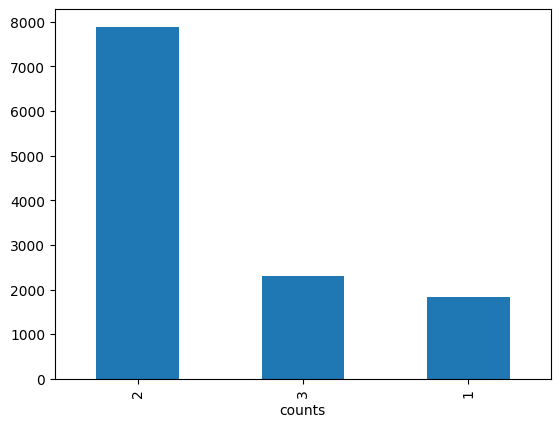

In [67]:
df_train['counts'].value_counts().plot(kind='bar');

### 🟡 Plot histogram of the number of samples per case


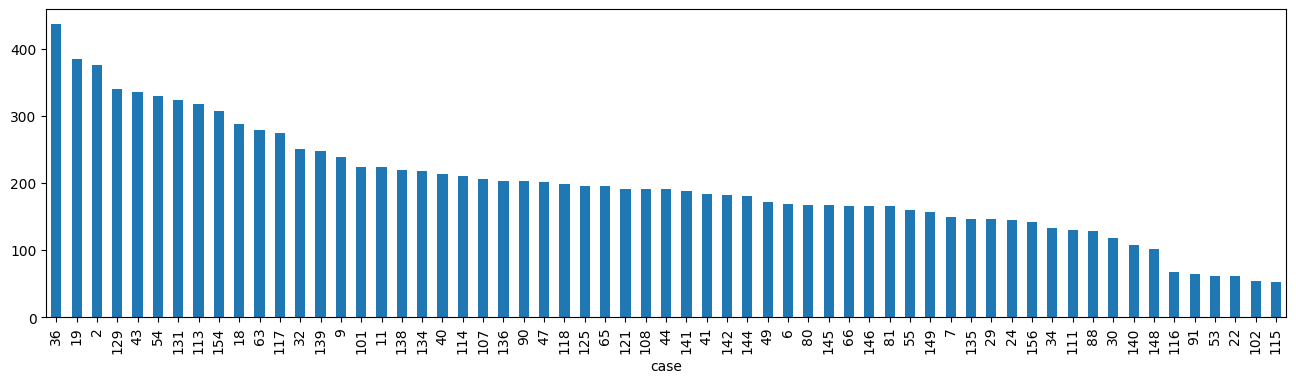

In [68]:
plt.figure(figsize=(16, 4))
df_train['case'].value_counts().plot(kind='bar');

### 🟡 Plot histogram of image sizes


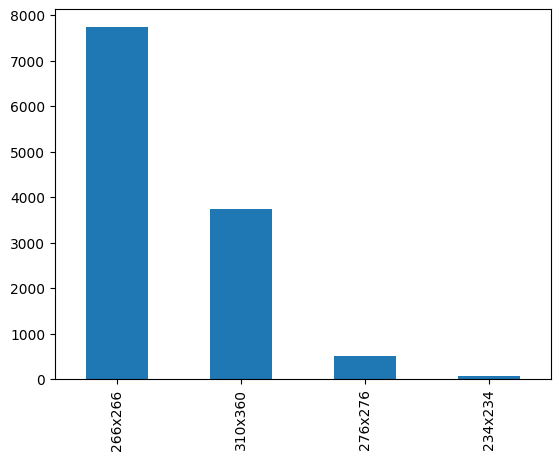

In [69]:
img_sizes = df_train['height'].apply(lambda x: str(x)) + 'x' + df_train['width'].apply(lambda x: str(x))
img_sizes.value_counts().plot(kind='bar');

### 🟡 Calculate the total RAM occupation by dataset


In [70]:
total_nbytes = 0

for path in df_train['path']:
  img = cv2.imread(path)
  total_nbytes += img.nbytes

print(total_nbytes/1e6)

3016.077948


In [71]:
120/12000

0.01

## 🟠 Custom dataset

In [72]:
def rle_decode(img_size, segments):
  mask = torch.zeros(3, img_size[0] * img_size[1], dtype=torch.int32)
  for i, segment in enumerate(segments):
    if str(segment) != 'nan':
      segment = segment.split()
      starts = np.array(segment[::2], dtype=np.int32) - 1
      ends = starts + np.array(segment[1::2], dtype=np.int32)
      for s, e in zip(starts, ends):
        mask[i, s:e] = 1
  return mask.reshape((3, img_size[0], img_size[1]))

In [73]:
class UWMadisonDataset(VisionDataset):

    def __init__(self, root, csv_file, transforms=None):

        super().__init__(root, transforms=transforms)

        self.df = pd.read_csv(os.path.join(root, csv_file))

        self.classes = ['large_bowel', 'small_bowel', 'stomach']

    def __getitem__(self, item):
        sample = self.df.iloc[item]

        img = Image.open(sample['path'])
        mask = rle_decode(img.size[::-1], sample[self.classes])

        img = tv_tensors.Image(img)
        mask = tv_tensors.Mask(mask)

        img, mask = self.transforms(img, mask)

        return img, mask

    def __len__(self):
        return self.df.shape[0]

In [74]:
transform_train = v2.Compose([
    v2.Resize(size=(234,), antialias=True),
    v2.RandomCrop(size=(224, 224)),
    v2.RandomPhotometricDistort(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Lambda(lambda x: (x - x.min()) / (x.max() - x.min())),
    v2.Normalize(mean=(0.5,), std=(0.5,)),
    v2.Lambda(lambda x: x.repeat(3, 1, 1)),
    ])

transform_eval = v2.Compose([
    v2.Resize(size=(224, 224), antialias=True),
    v2.Lambda(lambda x: (x - x.min()) / (x.max() - x.min())),
    v2.Normalize(mean=(0.5,), std=(0.5,)),
    v2.Lambda(lambda x: x.repeat(3, 1, 1)),
    ])

In [75]:
train_set = UWMadisonDataset(root, 'train-subset.csv', transforms=transform_train)

valid_set = UWMadisonDataset(root, 'valid-subset.csv', transforms=transform_eval)

test_set = UWMadisonDataset(root, 'test-subset.csv', transforms=transform_eval)

len(train_set), len(valid_set), len(test_set)

(12030, 1493, 3067)

torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) [-1.0, 1.0] tensor([0., 1.])


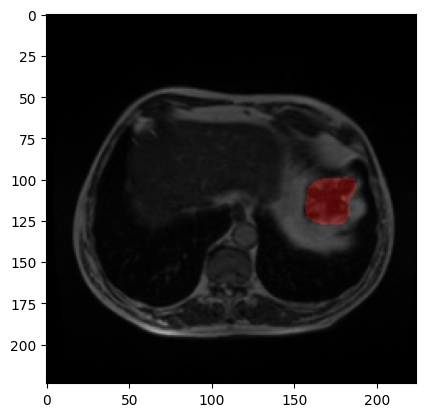

In [76]:
item = random.randint(0, len(train_set))
img, mask = train_set[item]
print(img.shape, mask.shape, [img.min().item(), img.max().item()], mask.unique())

plt.imshow(img[0], cmap='gray')
plt.imshow(mask.permute(1, 2, 0), alpha=0.3);

torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) [-1.0, 1.0] tensor([0., 1.])


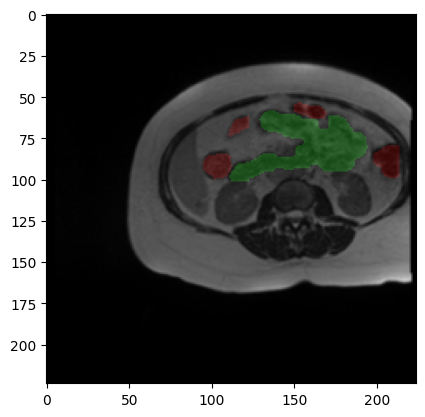

In [77]:
item = random.randint(0, len(test_set))
img, mask = test_set[item]
print(img.shape, mask.shape, [img.min().item(), img.max().item()], mask.unique())

plt.imshow(img[0], cmap='gray')
plt.imshow(mask.permute(1, 2, 0), alpha=0.20);

## 🟠 Dataloader

In [78]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [79]:
imgs, msks = next(iter(train_loader))
imgs.shape, imgs.dtype, msks.shape, msks.dtype

(torch.Size([32, 3, 224, 224]),
 torch.float32,
 torch.Size([32, 3, 224, 224]),
 torch.float32)

# 🔴 **Model**

In [86]:
model = smp.Unet(encoder_name=backbone, encoder_weights='imagenet',
                in_channels=3, classes=3)
model

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 166MB/s]


Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [87]:
imgs, masks = next(iter(train_loader))
model(imgs).shape

torch.Size([32, 3, 224, 224])

# 🔴 **Config**

In [88]:
loss_fn = smp.losses.DiceLoss(mode='multilabel')

In [89]:
metric = Dice().to(device)

In [90]:
if wandb_enable:
    key_file = '/content/key'

    if os.path.exists(key_file):
        with open(key_file) as f:
            key = f.readline().strip()
        wandb.login(key=key)
    else:
        print("Key file does not exist. Please create the key file with your wandb API key.")

# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [91]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = MeanMetric()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), weight=len(targets))
      metric.update(outputs, targets.to(torch.int16))

      tepoch.set_postfix(loss=loss_train.compute().item(),
                         metric=metric.compute().item())

  return model, loss_train.compute().item(), metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [92]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = MeanMetric()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), weight=len(targets))

      metric(outputs, targets.to(torch.int16))

  return loss_eval.compute().item(), metric.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
model = smp.Unet(encoder_name=backbone, encoder_weights='imagenet', classes=num_classes).to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs, targets)

print(loss)

tensor(0.9712, device='cuda:0')


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
mini_valid_size = 100
_, mini_valid_dataset = random_split(valid_set, (len(valid_set)-mini_valid_size, mini_valid_size))
mini_valid_loader = DataLoader(mini_valid_dataset, 20, shuffle=True)

In [ ]:
model = smp.Unet(encoder_name=backbone, encoder_weights='imagenet',
                 in_channels=3, classes=num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
loss_fn = smp.losses.DiceLoss(mode='multilabel')

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_valid_loader, loss_fn, optimizer, metric, epoch+1)

Epoch 50: 100%|██████████| 5/5 [00:02<00:00,  2.22batch/s, loss=0.0943, metric=0.907]


In [ ]:
torch.cuda.empty_cache()

### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs = 3

for lr in [0.9, 0.5, 0.3, 0.1, 0.01, 0.001]:
  print(f'LR={lr}')

  model = smp.Unet(encoder_name=backbone, encoder_weights='imagenet', classes=num_classes, in_channels=3).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, valid_loader, loss_fn, optimizer, metric, epoch+1)

  print()

LR=0.9


Epoch 3: 100%|████████████████████████████████████████████| 47/47 [00:34<00:00,  1.37batch/s, loss=0.621, metric=0.386]



LR=0.5


Epoch 3: 100%|████████████████████████████████████████████| 47/47 [00:34<00:00,  1.35batch/s, loss=0.625, metric=0.372]



LR=0.3


Epoch 3: 100%|████████████████████████████████████████████| 47/47 [00:34<00:00,  1.36batch/s, loss=0.617, metric=0.372]



LR=0.1


Epoch 3: 100%|████████████████████████████████████████████| 47/47 [00:34<00:00,  1.36batch/s, loss=0.629, metric=0.368]



LR=0.01


Epoch 3: 100%|██████████████████████████████████████████████| 47/47 [00:34<00:00,  1.37batch/s, loss=0.93, metric=0.08]



LR=0.001


Epoch 3: 100%|███████████████████████████████████████████| 47/47 [00:34<00:00,  1.36batch/s, loss=0.949, metric=0.0482]

In [ ]:
torch.cuda.empty_cache()

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
num_epochs = 5

for lr in [1e3, 1e4, 1e5]:
  for wd in [0.3, 0.5, 0.9]:
    print(f'LR={lr}, WD={wd}')

    model = smp.Unet(encoder_name=backbone, encoder_weights='imagenet', classes=num_classes, in_channels=3).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in range(num_epochs):
      model, _, _ = train_one_epoch(model, valid_loader, loss_fn, optimizer, metric, epoch+1)

    print()

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
model =

In [ ]:
lr =
wd =
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs =

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_set,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_set,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

## 🟠 Main Loop

In [130]:
torch.cuda.empty_cache()

🔰 Define model.

In [131]:
set_seed(seed)
model = model = smp.Unet(encoder_name=backbone, encoder_weights='imagenet', in_channels=3, classes=num_classes).to(device)

In [132]:
# model = torch.load('model.pt')

🔰 Define optimizer and Set learning rate and weight decay.

In [133]:
set_seed(seed)
lr = 0.3
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15], gamma=0.1)

🔰 Initialize `wandb`

In [134]:
if wandb_enable:
  wandb.init(
      project='segmentation',
      name=wandb_arg_name,
      config={
          'lr': lr,
          'momentum': momentum,
          'batch_size': batch_size,
          # 'seq_len': seq_len,
          # 'hidden_dim': hidden_dim,
          # 'embedding_dim': embedding_dim,
          # 'num_layers': num_layers,
          # 'dropout_embed': dropoute,
          # 'dropout_in_lstm': dropouti,
          # 'dropout_h_lstm': dropouth,
          # 'dropout_out_lstm': dropouto,
          # 'clip': clip,
      }
  )

🔰 Write code to train the model for `num_epochs` epoches.

In [135]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [136]:
num_epochs = 20

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch+1)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  if wandb_enable:
    wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}, LR = {lr_scheduler.get_last_lr()[0]}')
  print()

  lr_scheduler.step()

  epoch_counter += 1

Epoch 1: 100%|██████████| 376/376 [04:37<00:00,  1.36batch/s, loss=0.442, metric=0.365]


Model Saved!
Valid: Loss = 0.5282, Metric = 0.5495, LR = 0.3



Epoch 2: 100%|██████████| 376/376 [04:37<00:00,  1.35batch/s, loss=0.212, metric=0.783]


Model Saved!
Valid: Loss = 0.5197, Metric = 0.5613, LR = 0.3



Epoch 3: 100%|██████████| 376/376 [04:37<00:00,  1.36batch/s, loss=0.182, metric=0.812]


Model Saved!
Valid: Loss = 0.4678, Metric = 0.5966, LR = 0.3



Epoch 4: 100%|██████████| 376/376 [04:37<00:00,  1.36batch/s, loss=0.173, metric=0.821]


Model Saved!
Valid: Loss = 0.3725, Metric = 0.69, LR = 0.3



Epoch 5: 100%|██████████| 376/376 [04:35<00:00,  1.36batch/s, loss=0.176, metric=0.818]


Model Saved!
Valid: Loss = 0.3373, Metric = 0.6951, LR = 0.3



Epoch 6: 100%|██████████| 376/376 [04:35<00:00,  1.36batch/s, loss=0.147, metric=0.847]


Model Saved!
Valid: Loss = 0.243, Metric = 0.7913, LR = 0.03



Epoch 7: 100%|██████████| 376/376 [04:35<00:00,  1.36batch/s, loss=0.137, metric=0.858]


Model Saved!
Valid: Loss = 0.2409, Metric = 0.7914, LR = 0.03



Epoch 8: 100%|██████████| 376/376 [04:38<00:00,  1.35batch/s, loss=0.132, metric=0.862]


Model Saved!
Valid: Loss = 0.2394, Metric = 0.7942, LR = 0.03



Epoch 9: 100%|██████████| 376/376 [04:38<00:00,  1.35batch/s, loss=0.129, metric=0.866]


Valid: Loss = 0.2399, Metric = 0.7968, LR = 0.03



Epoch 10: 100%|██████████| 376/376 [04:38<00:00,  1.35batch/s, loss=0.126, metric=0.869]


Valid: Loss = 0.2409, Metric = 0.7909, LR = 0.03



Epoch 11: 100%|██████████| 376/376 [04:44<00:00,  1.32batch/s, loss=0.124, metric=0.871]


Model Saved!
Valid: Loss = 0.2337, Metric = 0.7994, LR = 0.003



Epoch 12: 100%|██████████| 376/376 [04:40<00:00,  1.34batch/s, loss=0.122, metric=0.873]


Model Saved!
Valid: Loss = 0.2336, Metric = 0.7983, LR = 0.003



Epoch 13: 100%|██████████| 376/376 [04:37<00:00,  1.36batch/s, loss=0.122, metric=0.873]


Valid: Loss = 0.2339, Metric = 0.7995, LR = 0.003



Epoch 14: 100%|██████████| 376/376 [04:37<00:00,  1.36batch/s, loss=0.121, metric=0.874]


Model Saved!
Valid: Loss = 0.2335, Metric = 0.799, LR = 0.003



Epoch 15: 100%|██████████| 376/376 [04:37<00:00,  1.35batch/s, loss=0.121, metric=0.874]


Valid: Loss = 0.2336, Metric = 0.7987, LR = 0.003



Epoch 16: 100%|██████████| 376/376 [04:38<00:00,  1.35batch/s, loss=0.121, metric=0.874]


Model Saved!
Valid: Loss = 0.2331, Metric = 0.799, LR = 0.00030000000000000003



Epoch 17: 100%|██████████| 376/376 [04:38<00:00,  1.35batch/s, loss=0.121, metric=0.874]


Valid: Loss = 0.2332, Metric = 0.7989, LR = 0.00030000000000000003



Epoch 18: 100%|██████████| 376/376 [04:37<00:00,  1.36batch/s, loss=0.121, metric=0.874]


Valid: Loss = 0.2335, Metric = 0.7989, LR = 0.00030000000000000003



Epoch 19: 100%|██████████| 376/376 [04:37<00:00,  1.36batch/s, loss=0.121, metric=0.874]


Valid: Loss = 0.2337, Metric = 0.7986, LR = 0.00030000000000000003



Epoch 20: 100%|██████████| 376/376 [04:37<00:00,  1.36batch/s, loss=0.121, metric=0.874]


Valid: Loss = 0.2333, Metric = 0.7989, LR = 0.00030000000000000003



In [137]:
if wandb_enable:
  wandb.finish()

In [138]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [140]:
drive_folder_path = '/content/drive/MyDrive/medical_image_segmentation'
os.makedirs(drive_folder_path, exist_ok=True)
destination_path = os.path.join(drive_folder_path, os.path.basename('/content/model.pt'))
shutil.move('/content/model.pt', destination_path)
print(f'File moved to: {destination_path}')

File moved to: /content/drive/MyDrive/medical_image_segmentation/model.pt


## 🟠 Plot

🔰 Plot learning curves

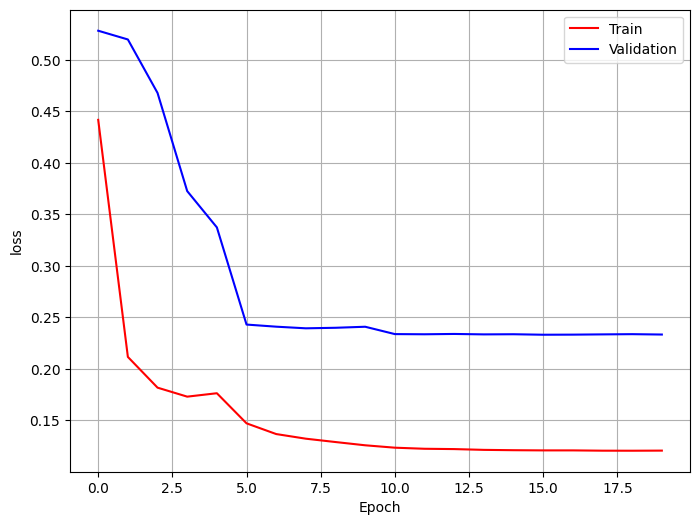

In [141]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
model_path = '/content/drive/MyDrive/medical_image_segmentation/model.pt'
shutil.move(model_path, '/content')

'/content/model.pt'

In [93]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

🔰 Test your model using data from the test set and images that are not present in the dataset.

In [94]:
test_loader = DataLoader(test_set, batch_size=32)

In [95]:
_, metric_test = evaluate(model, test_loader, loss_fn, metric)
metric_test

0.7980851531028748

# 🔴 **Segment**

In [96]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [97]:
def segment(image, model):
  with torch.inference_mode():
    prediction = model(image)
    return torch.sigmoid(prediction).cpu()

In [98]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

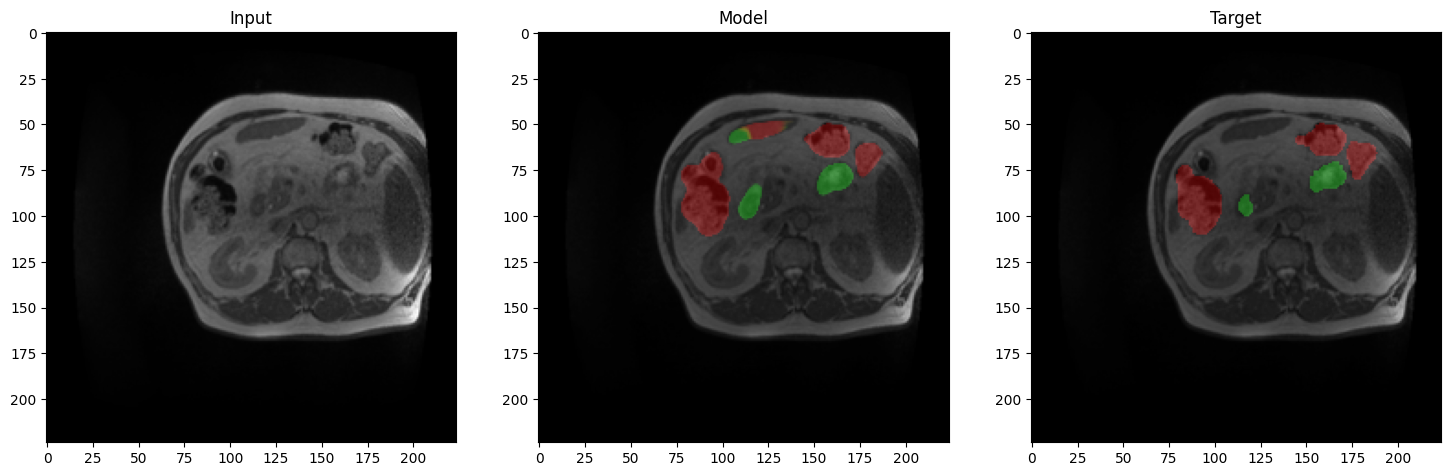

In [99]:
img, mask = next(iter(test_loader))

output = segment(img.to(device), model)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(img[0, 0], cmap='gray');
plt.title('Input')

plt.subplot(1, 3, 2)
plt.imshow(img[0, 0], cmap='gray');
plt.imshow(output[0].permute(1, 2, 0), alpha=0.3);
plt.title('Model')

plt.subplot(1, 3, 3)
plt.imshow(img[0, 0], cmap='gray');
plt.imshow(mask[0].permute(1, 2, 0).float(), alpha=0.3);
plt.title('Target');

# 🔴 **Experiments**

In [100]:
valid_set = UWMadisonDataset(root, 'valid-subset.csv', transforms=transform_eval)
test_set = UWMadisonDataset(root, 'test-subset.csv', transforms=transform_eval)

new_test_set = ConcatDataset([valid_set, test_set])
print(len(new_test_set))

new_test_loader = DataLoader(new_test_set, batch_size=10)

4560


In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

In [107]:
outputs = []

for img, mask in new_test_loader:
  output = segment(img.to(device), model)
  outputs.append(output)

## 🟠 Class-wise Dice Scores

In [108]:
large_bowel_dice, small_bowel_dice, stomach_dice = Dice(), Dice(), Dice()

for output, (_, mask) in zip(outputs, new_test_loader):
  mask = mask.to(torch.int32)
  large_bowel_dice.update(output[0, 0], mask[0, 0])
  small_bowel_dice.update(output[0, 1], mask[0, 1])
  stomach_dice.update(output[0, 2], mask[0, 2])

print(f'Large Bowel Dice: {large_bowel_dice.compute().item()}')
print(f'Small Bowel Dice: {small_bowel_dice.compute().item()}')
print(f'Stomach Dice: {stomach_dice.compute().item()}')

Large Bowel Dice: 0.8132762312889099
Small Bowel Dice: 0.7370530366897583
Stomach Dice: 0.8681455254554749


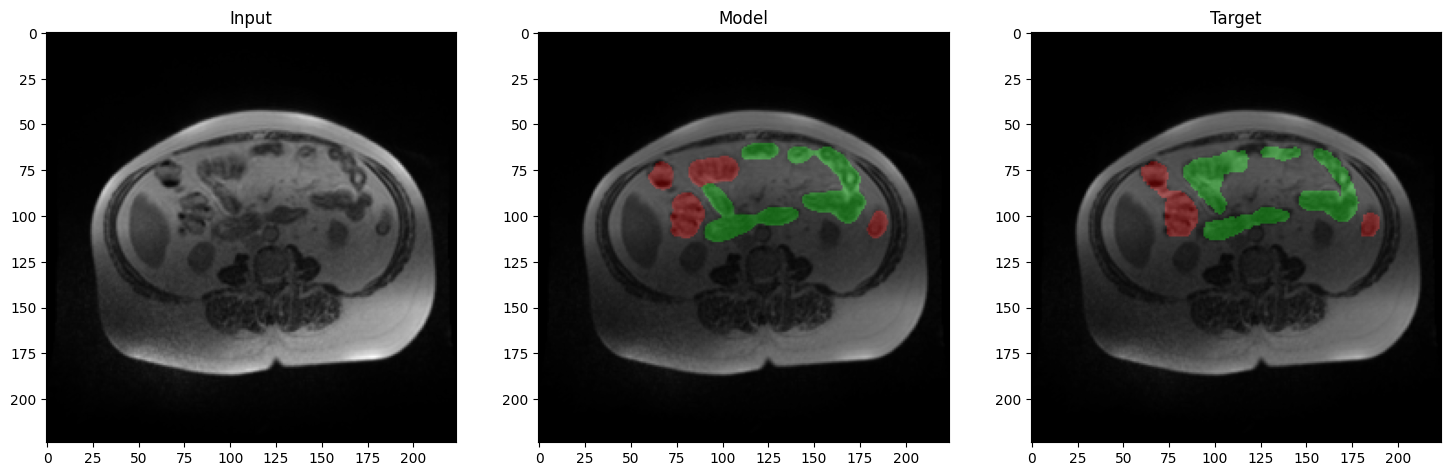

In [110]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(img[0, 0], cmap='gray');
plt.title('Input')

plt.subplot(1, 3, 2)
plt.imshow(img[0, 0], cmap='gray');
plt.imshow(output[0].permute(1, 2, 0), alpha=0.3);
plt.title('Model')

plt.subplot(1, 3, 3)
plt.imshow(img[0, 0], cmap='gray');
plt.imshow(mask[0].permute(1, 2, 0).float(), alpha=0.3);
plt.title('Target');